<a href="https://colab.research.google.com/github/emrekzltp/derin-ogrenme-projem/blob/main/Zat%C3%BCrreV02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')

proje_yolu = '/content/drive/MyDrive/ZaturreProjesi'
if os.path.exists(proje_yolu):
    print(f" Klasör bulundu: {os.listdir(proje_yolu)}")
else:
    print("Hata: 'ZaturreProjesi' klasörü Drive'da bulunamadı!")

Mounted at /content/drive
 Klasör bulundu: ['archive.zip', 'en_iyi_zaturre_modeli.keras']


In [ ]:
import zipfile

zip_yolu = '/content/drive/MyDrive/ZaturreProjesi/archive.zip'
hedef_klasor = '/content/dataset'

if os.path.exists(hedef_klasor):
    import shutil
    shutil.rmtree(hedef_klasor)

print(" Veriler zipten çıkarılıyor, lütfen bekleyin...")
with zipfile.ZipFile(zip_yolu, 'r') as zip_ref:
    zip_ref.extractall(hedef_klasor)

print(" Çıkarma işlemi tamamlandı!")

 Veriler zipten çıkarılıyor, lütfen bekleyin...
 Çıkarma işlemi tamamlandı!


In [ ]:

def yol_bul(root_path):
    for root, dirs, files in os.walk(root_path):
        if 'train' in dirs and 'NORMAL' in os.listdir(os.path.join(root, 'train')):
            return root
    return None

ana_yol = yol_bul('/content/dataset')
if ana_yol:
    print(f" Resimlerin merkezi kesinleşti: {ana_yol}")
else:
    print(" Resimler bulunamadı, lütfen zipten çıkarma adımını kontrol et.")

 Resimlerin merkezi kesinleşti: /content/dataset/chest_xray


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_yolu = os.path.join(ana_yol, 'train')
test_yolu = os.path.join(ana_yol, 'test')

# 2. Veri Artırma Ayarları
train_datagen = ImageDataGenerator(
    rescale=1./255,           # Renk değerlerini 0-1 arasına sıkıştırma
    rotation_range=15,        # Resimleri hafifçe döndürme
    width_shift_range=0.1,    # Sağa-sola kaydırma
    height_shift_range=0.1,   # Yukarı-aşağı kaydırma
    zoom_range=0.2,           # Yakınlaştırma yapma
    horizontal_flip=True,     # Yatayda çevirme
    validation_split=0.2      # %20'sini doğrulama için ayırma
)

test_datagen = ImageDataGenerator(rescale=1./255)

# 3. Yükleyicileri Oluşturma
train_generator = train_datagen.flow_from_directory(
    train_yolu, target_size=(224, 224), batch_size=32, class_mode='binary', subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_yolu, target_size=(224, 224), batch_size=32, class_mode='binary', subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_yolu, target_size=(224, 224), batch_size=32, class_mode='binary', shuffle=False
)

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers

# Hazır VGG16 modelini yükleme işlemi
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # VGG16'nın kendi bilgilerini bozma

#kendi karar mekanizmalarım
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid') # Zatürre mi değil mi? (0 veya 1)
])

model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
model_kayit_yolu = '/content/drive/MyDrive/ZaturreProjesi/en_iyi_zaturre_modeli.keras'

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

checkpoint = ModelCheckpoint(model_kayit_yolu, monitor='val_accuracy', save_best_only=True, verbose=1)

print(" Eğitim Başlıyor... Her tur (epoch) sonunda Drive'a kontrol edilecek.")

history = model.fit(
    train_generator,
    epochs=15,                 # 15 tur boyunca eğitilecek
    validation_data=val_generator,
    callbacks=[early_stop, checkpoint]
)

 Eğitim Başlıyor... Her tur (epoch) sonunda Drive'a kontrol edilecek.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 712ms/step - accuracy: 0.5083 - loss: 0.8343
Epoch 1: val_accuracy improved from -inf to 0.74305, saving model to /content/drive/MyDrive/ZaturreProjesi/en_iyi_zaturre_modeli.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 140s 962ms/step - accuracy: 0.5091 - loss: 0.8332 - val_accuracy: 0.7430 - val_loss: 0.5347
Epoch 2/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 683ms/step - accuracy: 0.7281 - loss: 0.5634
Epoch 2: val_accuracy did not improve from 0.74305
131/131 ━━━━━━━━━━━━━━━━━━━━ 131s 999ms/step - accuracy: 0.7281 - loss: 0.5633 - val_accuracy: 0.7430 - val_loss: 0.4762
Epoch 3/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 683ms/step - accuracy: 0.7482 - loss: 0.5060
Epoch 3: val_accuracy improved from 0.74305 to 0.75839, saving model to /content/drive/MyDrive/ZaturreProjesi/en_iyi_zaturre_modeli.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 111s 849ms/step - accuracy: 0.7483 - loss: 0.5059 - val_accuracy: 0.7584 - val_loss: 0.4265
Epoch 4/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 678ms/

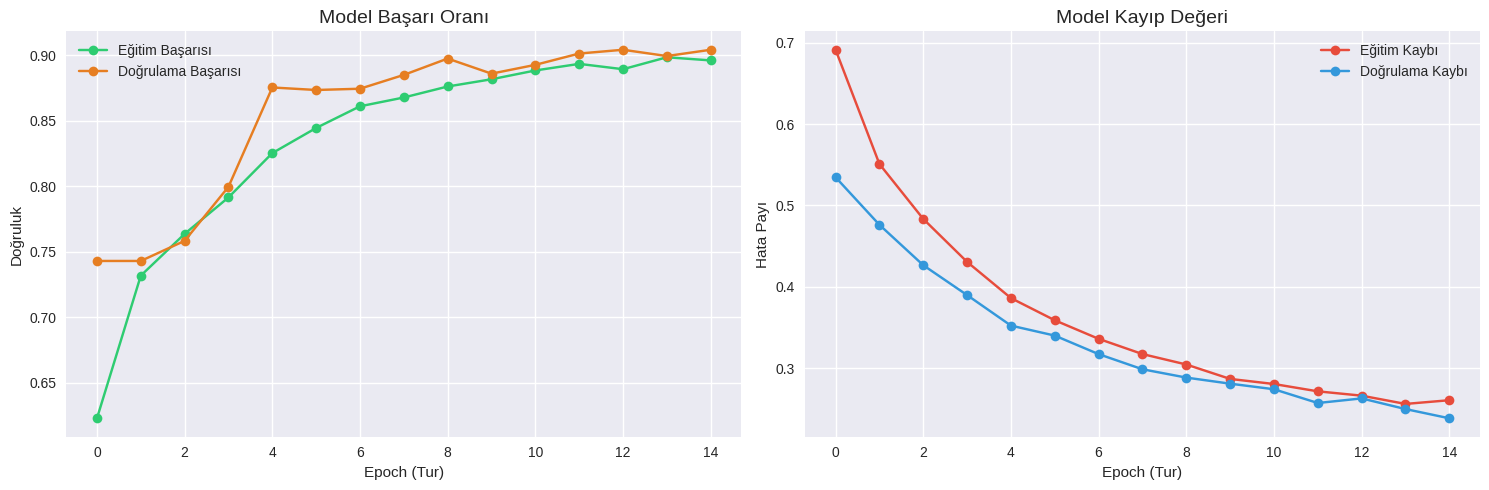

In [ ]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# 1. Başarı Oranı (Accuracy) Grafiği
ax1.plot(history.history['accuracy'], label='Eğitim Başarısı', color='#2ecc71', marker='o')
ax1.plot(history.history['val_accuracy'], label='Doğrulama Başarısı', color='#e67e22', marker='o')
ax1.set_title('Model Başarı Oranı', fontsize=14)
ax1.set_xlabel('Epoch (Tur)')
ax1.set_ylabel('Doğruluk')
ax1.legend()

# 2. Kayıp (Loss) Grafiği
ax2.plot(history.history['loss'], label='Eğitim Kaybı', color='#e74c3c', marker='o')
ax2.plot(history.history['val_loss'], label='Doğrulama Kaybı', color='#3498db', marker='o')
ax2.set_title('Model Kayıp Değeri', fontsize=14)
ax2.set_xlabel('Epoch (Tur)')
ax2.set_ylabel('Hata Payı')
ax2.legend()

plt.tight_layout()
plt.show()

📋 Test verileri analiz ediliyor...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 747ms/step


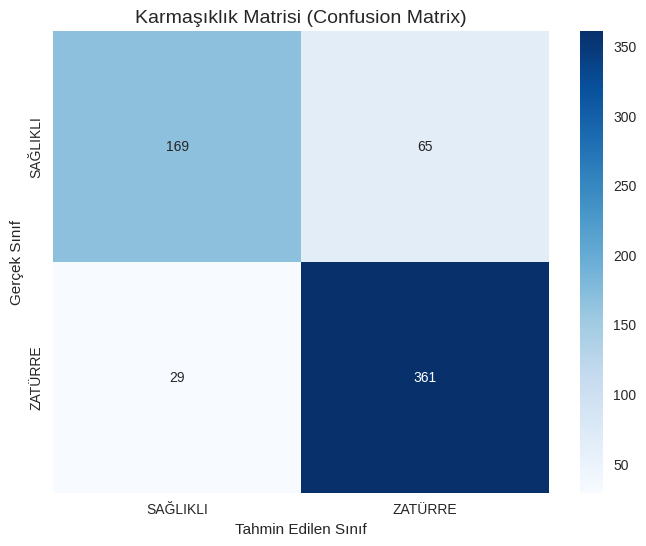


📝 Detaylı Sınıflandırma Raporu:
              precision    recall  f1-score   support

      NORMAL       0.85      0.72      0.78       234
   PNEUMONIA       0.85      0.93      0.88       390

    accuracy                           0.85       624
   macro avg       0.85      0.82      0.83       624
weighted avg       0.85      0.85      0.85       624



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

# Test verileri üzerinde tahmin yapma
print(" Test verileri analiz ediliyor...")
test_generator.reset()
y_pred_prob = model.predict(test_generator)
y_pred = (y_pred_prob > 0.5).astype(int)
y_true = test_generator.classes

# 1. Karmaşıklık Matrisi
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['SAĞLIKLI', 'ZATÜRRE'],
            yticklabels=['SAĞLIKLI', 'ZATÜRRE'])
plt.title('Karmaşıklık Matrisi (Confusion Matrix)', fontsize=14)
plt.ylabel('Gerçek Sınıf')
plt.xlabel('Tahmin Edilen Sınıf')
plt.show()

# 2. Detaylı İstatistik Raporu
print("\n Detaylı Sınıflandırma Raporu:")
print(classification_report(y_true, y_pred, target_names=['NORMAL', 'PNEUMONIA']))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


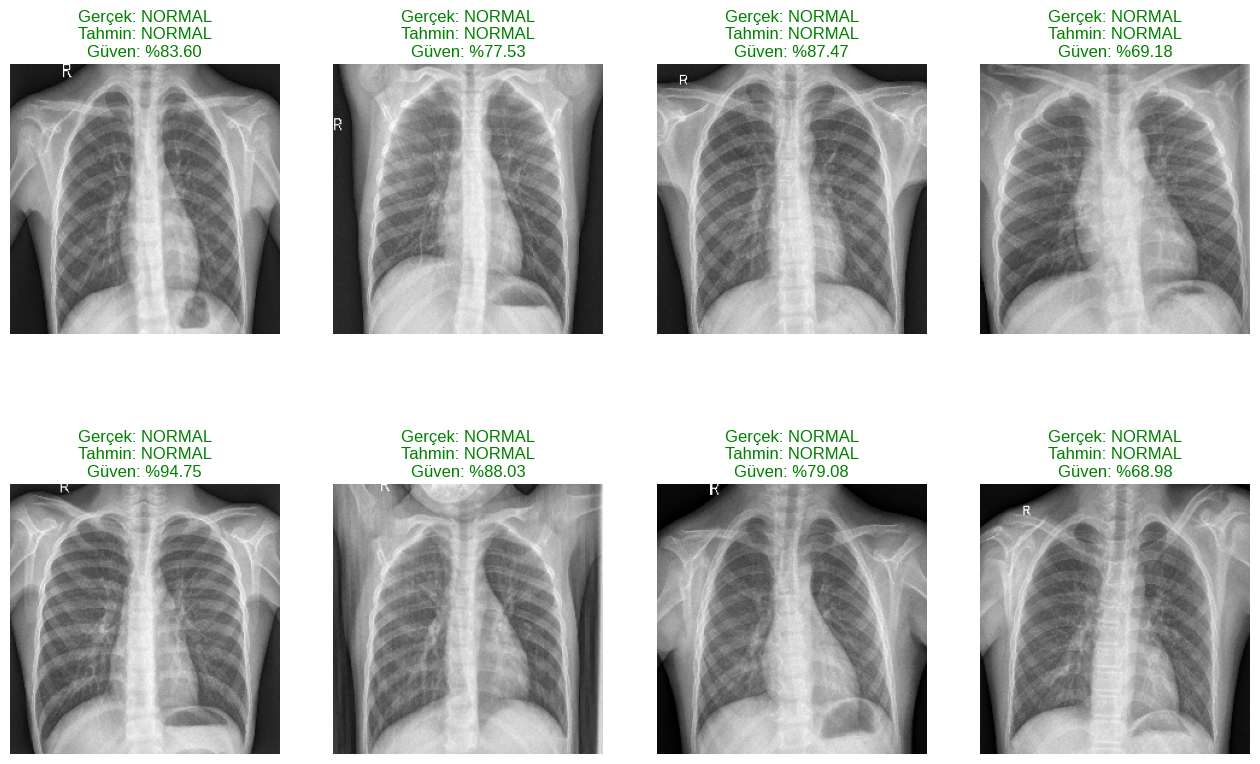

In [ ]:
def tahmin_goster(generator, model):
    classes = ['NORMAL', 'PNEUMONIA']
    plt.figure(figsize=(16, 10))

    # Test setinden rastgele resimler al
    x, y = next(generator)
    preds = model.predict(x)

    for i in range(8):
        plt.subplot(2, 4, i+1)
        plt.imshow(x[i])

        true_label = classes[int(y[i])]
        pred_label = classes[1 if preds[i] > 0.5 else 0]
        prob = preds[i][0] if pred_label == 'PNEUMONIA' else 1 - preds[i][0]

        color = 'green' if true_label == pred_label else 'red'

        plt.title(f"Gerçek: {true_label}\nTahmin: {pred_label}\nGüven: %{prob*100:.2f}", color=color)
        plt.axis('off')
    plt.show()

tahmin_goster(test_generator, model)

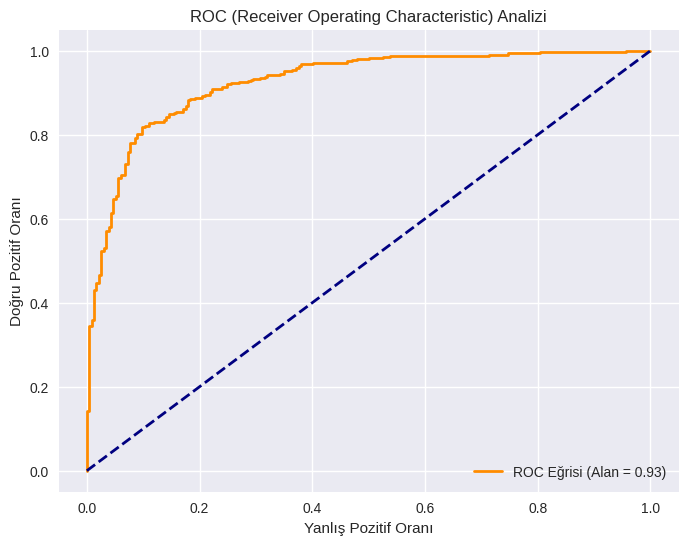

In [ ]:
from sklearn.metrics import roc_curve, auc

# ROC verilerini hesaplama
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Eğrisi (Alan = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Yanlış Pozitif Oranı')
plt.ylabel('Doğru Pozitif Oranı')
plt.title('ROC (Receiver Operating Characteristic) Analizi')
plt.legend(loc="lower right")
plt.show()

In [ ]:
def hatalari_goster(generator, model):
    indices = np.where(y_pred.flatten() != y_true)[0]
    plt.figure(figsize=(16, 10))
    for i, idx in enumerate(indices[:8]): # İlk 8 hatayı göster
        plt.subplot(2, 4, i+1)
        plt.title(f"Gerçek: {y_true[idx]}\nTahmin: {y_pred[idx]}")
        plt.axis('off')
    print(f"Toplam hata sayısı: {len(indices)}")

In [ ]:
import gradio as gr
import numpy as np
import tensorflow as tf
import cv2
from tensorflow.keras.preprocessing import image

def get_gradcam_heatmap(img_array, model, last_conv_layer_name):
    base_model = model.layers[0]

    grad_model = tf.keras.models.Model(
        [base_model.inputs], [base_model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)

        class_channel = preds[:, 0]

    # Gradyanları hesapla
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Negatif değerleri temizleme ve 0-1 arasına normalize etme
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-10)
    return heatmap.numpy()

def pnomoni_tani_sistemi(input_img):
    if input_img is None:
        return "Lütfen bir resim yükleyin.", None

    # Resmi modele hazırla
    img = cv2.resize(input_img, (224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # Tahmin yap
    preds = model.predict(img_array)
    score = preds[0][0]

    # Etiket ve Güven Skoru
    label = " ZATÜRRE (PNEUMONIA)" if score > 0.5 else "SAĞLIKLI (NORMAL)"
    confidence = score if score > 0.5 else 1 - score
    result_text = f"TEŞHİS: {label}\nGüven Oranı: %{confidence*100:.2f}"

    heatmap = get_gradcam_heatmap(img_array, model, "block5_conv3")

    img_cv = np.uint8(img)
    heatmap = cv2.resize(heatmap, (img_cv.shape[1], img_cv.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    output_img = cv2.addWeighted(img_cv, 0.6, heatmap, 0.4, 0)

    return result_text, output_img

# 3. ARAYÜZÜ BAŞLAT
demo = gr.Interface(
    fn=pnomoni_tani_sistemi,
    inputs=gr.Image(label="Röntgen Yükle"),
    outputs=[
        gr.Textbox(label="Analiz Sonucu"),
        gr.Image(label="Yapay Zeka Odak Analizi (Heatmap)")
    ],
    title=" Akıllı Zatürre Tanı Sistemi",
    description="Röntgeni sürükleyin veya yükleyin. Sistem hem teşhis koyar hem de ciğerdeki şüpheli bölgeyi işaretler."
)

demo.launch(share=True, inline=False)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://f48f4cd2d05f50d7a1.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
import gradio as gr
import tensorflow as tf
import numpy as np
import cv2

def get_gradcam_heatmap(img_array, model_to_use, last_conv_layer_name):
    # VGG16 modelin genellikle Sequential'ın ilk katmanıdır
    # Eğer model.layers[0] VGG16 ise ona ulaşırız
    try:
        base_model = model_to_use.layers[0]
        # Gradyanları hesaplamak için fonksiyonel yapı
        grad_model = tf.keras.models.Model(
            [base_model.inputs],
            [base_model.get_layer(last_conv_layer_name).output, model_to_use.output]
        )
    except:
        grad_model = tf.keras.models.Model(
            [model_to_use.inputs],
            [model_to_use.get_layer(last_conv_layer_name).output, model_to_use.output]
        )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        class_channel = preds[:, 0]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-10)
    return heatmap.numpy()

# 2. Ana Tahmin Fonksiyonu
def pnomoni_tahlil_et(input_img):
    if input_img is None:
        return "Lütfen resim yükleyin.", None

    if 'model' in locals() or 'model' in globals():
        active_model = model
    elif 'trained_model' in locals() or 'trained_model' in globals():
        active_model = trained_model
    else:
        return "HATA: Hafızada eğitilmiş bir model bulunamadı! Lütfen eğitim hücresini çalıştırın.", None

    # Resmi hazırla
    img = cv2.resize(input_img, (224, 224))
    img_array = np.expand_dims(img, axis=0) / 255.0

    # Tahmin yap
    prediction = active_model.predict(img_array)[0][0]

    # Karar ve Skor
    if prediction > 0.5:
        label = " ZATÜRRE (PNEUMONIA) TESPİT EDİLDİ"
        conf = prediction
    else:
        label = "NORMAL (SAĞLIKLI)"
        conf = 1 - prediction

    result_txt = f"TEŞHİS: {label}\nDoğruluk Güveni: %{conf*100:.2f}"

    try:
        heatmap = get_gradcam_heatmap(img_array, active_model, "block5_conv3")
        heatmap_resized = cv2.resize(heatmap, (input_img.shape[1], input_img.shape[0]))
        heatmap_resized = np.uint8(255 * heatmap_resized)
        heatmap_color = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)


        output_img = cv2.addWeighted(input_img, 0.6, heatmap_color, 0.4, 0)
    except Exception as e:
        print(f"Isı haritası hatası: {e}")
        output_img = input_img

    return result_txt, output_img

# 3. Arayüz Tasarımı (Gradio)
demo = gr.Interface(
    fn=pnomoni_tahlil_et,
    inputs=gr.Image(label="Akciğer Röntgeni Yükle"),
    outputs=[
        gr.Textbox(label="Teşhis Sonucu"),
        gr.Image(label="Yapay Zeka Odak Analizi (Grad-CAM)")
    ],
    title="🏥 Akıllı Zatürre Tanı Sistemi",
    description="Eğitilmiş modelinizi test edin. Isı haritası, yapay zekanın akciğerde nereye baktığını gösterir.",
    theme="soft"
)

demo.launch(share=True, inline=False, debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://e10050140d53001bad.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/fastapi/applications.py", line 1139, in __call__
    await super().__call__(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/applications.py", line 107, in __call__
    await self.middleware_stack(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py", line 186, in __call__
    raise exc
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py",

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Isı haritası hatası: "Exception encountered when calling Functional.call().\n\n\x1b136272983046960\x1b\n\nArguments received by Functional.call():\n  • inputs=array([[[[0.02745098, 0.02745098, 0.02745098],\n         [0.04705882, 0.04705882, 0.04705882],\n         [0.0627451 , 0.0627451 , 0.0627451 ],\n         ...,\n         [0.02352941, 0.02352941, 0.02352941],\n         [0.97254902, 0.97254902, 0.97254902],\n         [0.02745098, 0.02745098, 0.02745098]],\n\n        [[0.02352941, 0.02352941, 0.02352941],\n         [0.04313725, 0.04313725, 0.04313725],\n         [0.05882353, 0.05882353, 0.05882353],\n         ...,\n         [0.01176471, 0.01176471, 0.01176471],\n         [0.        , 0.        , 0.        ],\n         [0.        , 0.        , 0.        ]],\n\n        [[0.02352941, 0.02352941, 0.02352941],\n         [0.03137255, 0.03137255, 0.03137255],\n         [0.05098039, 0.05098039, 0.05098039],\n         ...,\n         [0.03529412, 0.03529412

/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/fastapi/applications.py", line 1139, in __call__
    await super().__call__(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/applications.py", line 107, in __call__


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


Isı haritası hatası: "Exception encountered when calling Functional.call().\n\n\x1b136272983046960\x1b\n\nArguments received by Functional.call():\n  • inputs=array([[[[0.        , 0.        , 0.        ],\n         [0.        , 0.        , 0.        ],\n         [0.        , 0.        , 0.        ],\n         ...,\n         [0.2       , 0.2       , 0.2       ],\n         [0.14901961, 0.14901961, 0.14901961],\n         [0.11764706, 0.11764706, 0.11764706]],\n\n        [[0.        , 0.        , 0.        ],\n         [0.        , 0.        , 0.        ],\n         [0.        , 0.        , 0.        ],\n         ...,\n         [0.20784314, 0.20784314, 0.20784314],\n         [0.16470588, 0.16470588, 0.16470588],\n         [0.09803922, 0.09803922, 0.09803922]],\n\n        [[0.        , 0.        , 0.        ],\n         [0.        , 0.        , 0.        ],\n         [0.        , 0.        , 0.        ],\n         ...,\n         [0.21568627, 0.21568627, 0.21568627],\n         [0.16470588, 

In [ ]:
import gradio as gr
import tensorflow as tf
import numpy as np
import cv2

def pnomoni_tahlil_sade(input_img):
    if input_img is None:
        return "Lütfen analiz için bir röntgen yükleyin."

    if 'model' in globals():
        active_model = model
    elif 'trained_model' in globals():
        active_model = trained_model
    else:
        return "HATA: Eğitilmiş model hafızada bulunamadı. Lütfen eğitim hücresini tekrar çalıştırın."

    #  Görüntü Ön İşleme ($224 \times 224$ boyutlandırma ve $1/255$ ölçekleme)
    img = cv2.resize(input_img, (224, 224))
    img_array = np.expand_dims(img, axis=0) / 255.0

    #  Tahmin Yap
    prediction = active_model.predict(img_array)[0][0]

    #  Sonuçları Belirle
    if prediction > 0.5:
        label = " ZATÜRRE (PNEUMONIA) TESPİT EDİLDİ"
        conf = prediction
    else:
        label = " NORMAL (SAĞLIKLI)"
        conf = 1 - prediction

    return f"TEŞHİS: {label}\n\nGüven Oranı: %{conf*100:.2f}"

#  Gradio Arayüz Tasarımı
demo = gr.Interface(
    fn=pnomoni_tahlil_sade,
    inputs=gr.Image(label="Akciğer Röntgeni Yükle"),
    outputs=gr.Textbox(label="Analiz Sonucu", lines=4),
    title="🏥 Akıllı Zatürre Tanı Sistemi",
    description="Röntgen dosyasını sürükleyip bırakın. Yapay zeka pediatrik verilerle eğitilmiştir.",
    theme="soft"
)


demo.launch(share=True, inline=False)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://bce31f70a749df17f5.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 562ms/step


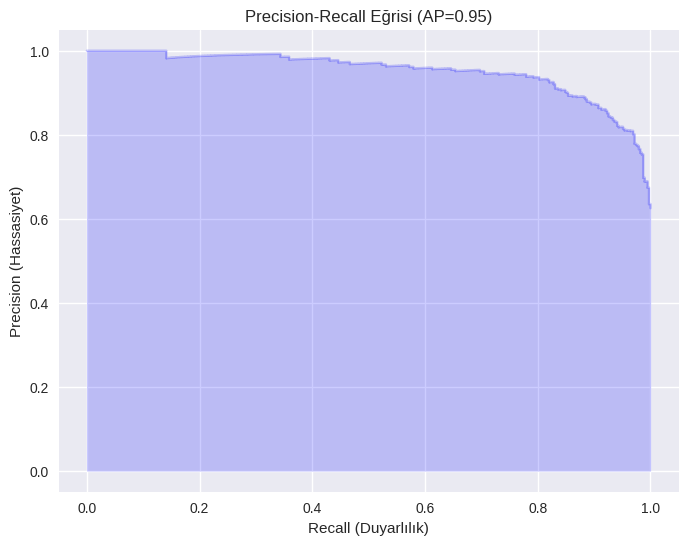

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

y_true = test_generator.classes
y_scores = model.predict(test_generator).flatten()

precision, recall, _ = precision_recall_curve(y_true, y_scores)
average_precision = average_precision_score(y_true, y_scores)

plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

plt.xlabel('Recall (Duyarlılık)')
plt.ylabel('Precision (Hassasiyet)')
plt.title(f'Precision-Recall Eğrisi (AP={average_precision:.2f})')
plt.grid(True)
plt.show()

🚨 Modelin en çok emin olup yanıldığı (False Positive/Negative) resimler:
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 421ms/step


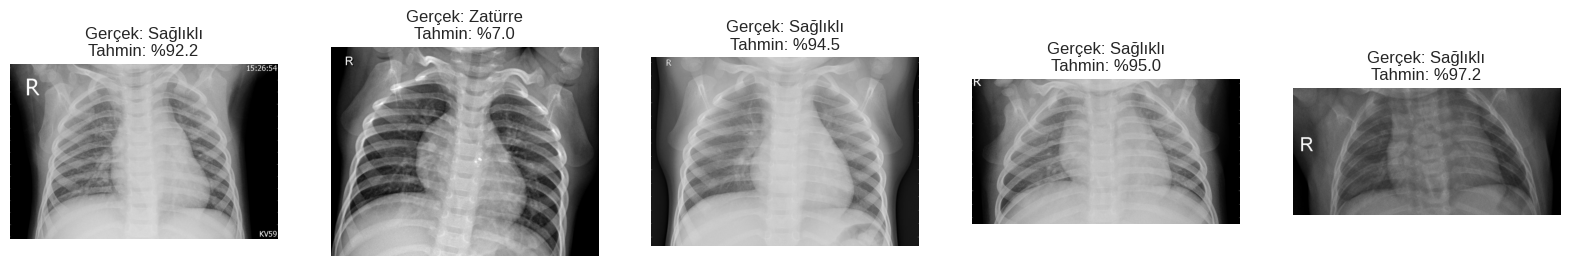

In [ ]:
def en_buyuk_hatalari_goster(generator, model, n_images=5):
    generator.reset()
    y_true = generator.classes
    y_pred_probs = model.predict(generator).flatten()

    # Hata miktarını hesapla (Mutlak fark)
    errors = np.abs(y_true - y_pred_probs)
    error_indices = np.argsort(errors)[-n_images:]

    plt.figure(figsize=(20, 4))
    for i, idx in enumerate(error_indices):

        img_path = os.path.join(generator.directory, generator.filenames[idx])
        img = plt.imread(img_path)

        plt.subplot(1, n_images, i+1)
        plt.imshow(img, cmap='gray')
        true_label = "Zatürre" if y_true[idx] == 1 else "Sağlıklı"
        pred_prob = y_pred_probs[idx]

        plt.title(f"Gerçek: {true_label}\nTahmin: %{pred_prob*100:.1f}")
        plt.axis('off')
    plt.show()

print(" Modelin en çok emin olup yanıldığı (False Positive/Negative) resimler:")
en_buyuk_hatalari_goster(test_generator, model)

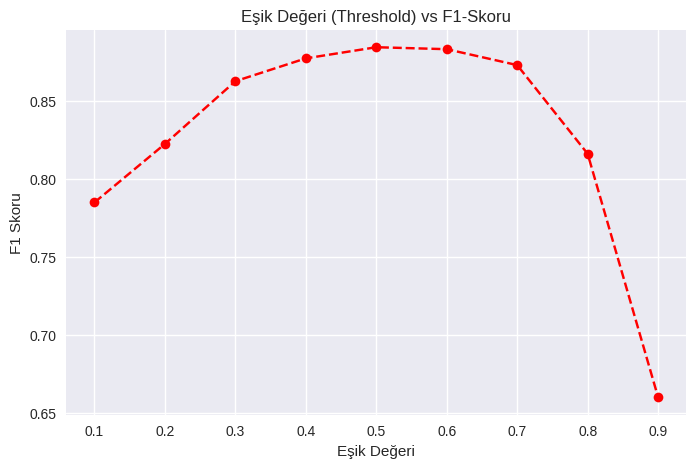

In [ ]:
from sklearn.metrics import f1_score

thresholds = np.arange(0.1, 1.0, 0.1)
f1_skorlari = []

for t in thresholds:
    y_pred_t = (y_scores > t).astype(int)
    f1_skorlari.append(f1_score(y_true, y_pred_t))

plt.figure(figsize=(8, 5))
plt.plot(thresholds, f1_skorlari, marker='o', linestyle='--', color='red')
plt.title("Eşik Değeri (Threshold) vs F1-Skoru")
plt.xlabel("Eşik Değeri")
plt.ylabel("F1 Skoru")
plt.grid(True)
plt.show()

In [ ]:
!pip install lime -q
from lime import lime_image
from skimage.segmentation import mark_boundaries

explainer = lime_image.LimeImageExplainer()

def lime_analizi(img_array):

    explanation = explainer.explain_instance(img_array[0].astype('double'),
                                             model.predict,
                                             top_labels=1, hide_color=0, num_samples=500)

    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0],
                                                 positive_only=True, num_features=5, hide_rest=False)

    plt.imshow(mark_boundaries(temp, mask))
    plt.title("LIME: Modelin Kararını Etkileyen Bölgeler")
    plt.axis('off')
    plt.show()


lime_analizi(img_array)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


NameError: name 'img_array' is not defined

In [ ]:

ilk_katman = model.layers[0].get_layer('block1_conv1')
ozellik_modeli = tf.keras.models.Model(inputs=model.layers[0].input, outputs=ilk_katman.output)

ozellik_haritasi = ozellik_modeli.predict(img_array)

plt.figure(figsize=(15, 15))
for i in range(16): # İlk 16 filtreyi göster
    plt.subplot(4, 4, i+1)
    plt.imshow(ozellik_haritasi[0, :, :, i], cmap='viridis')
    plt.axis('off')
plt.suptitle("Modelin İlk Katmanda Gördüğü Detaylar (Kenarlar ve Dokular)")
plt.show()

NameError: name 'img_array' is not defined

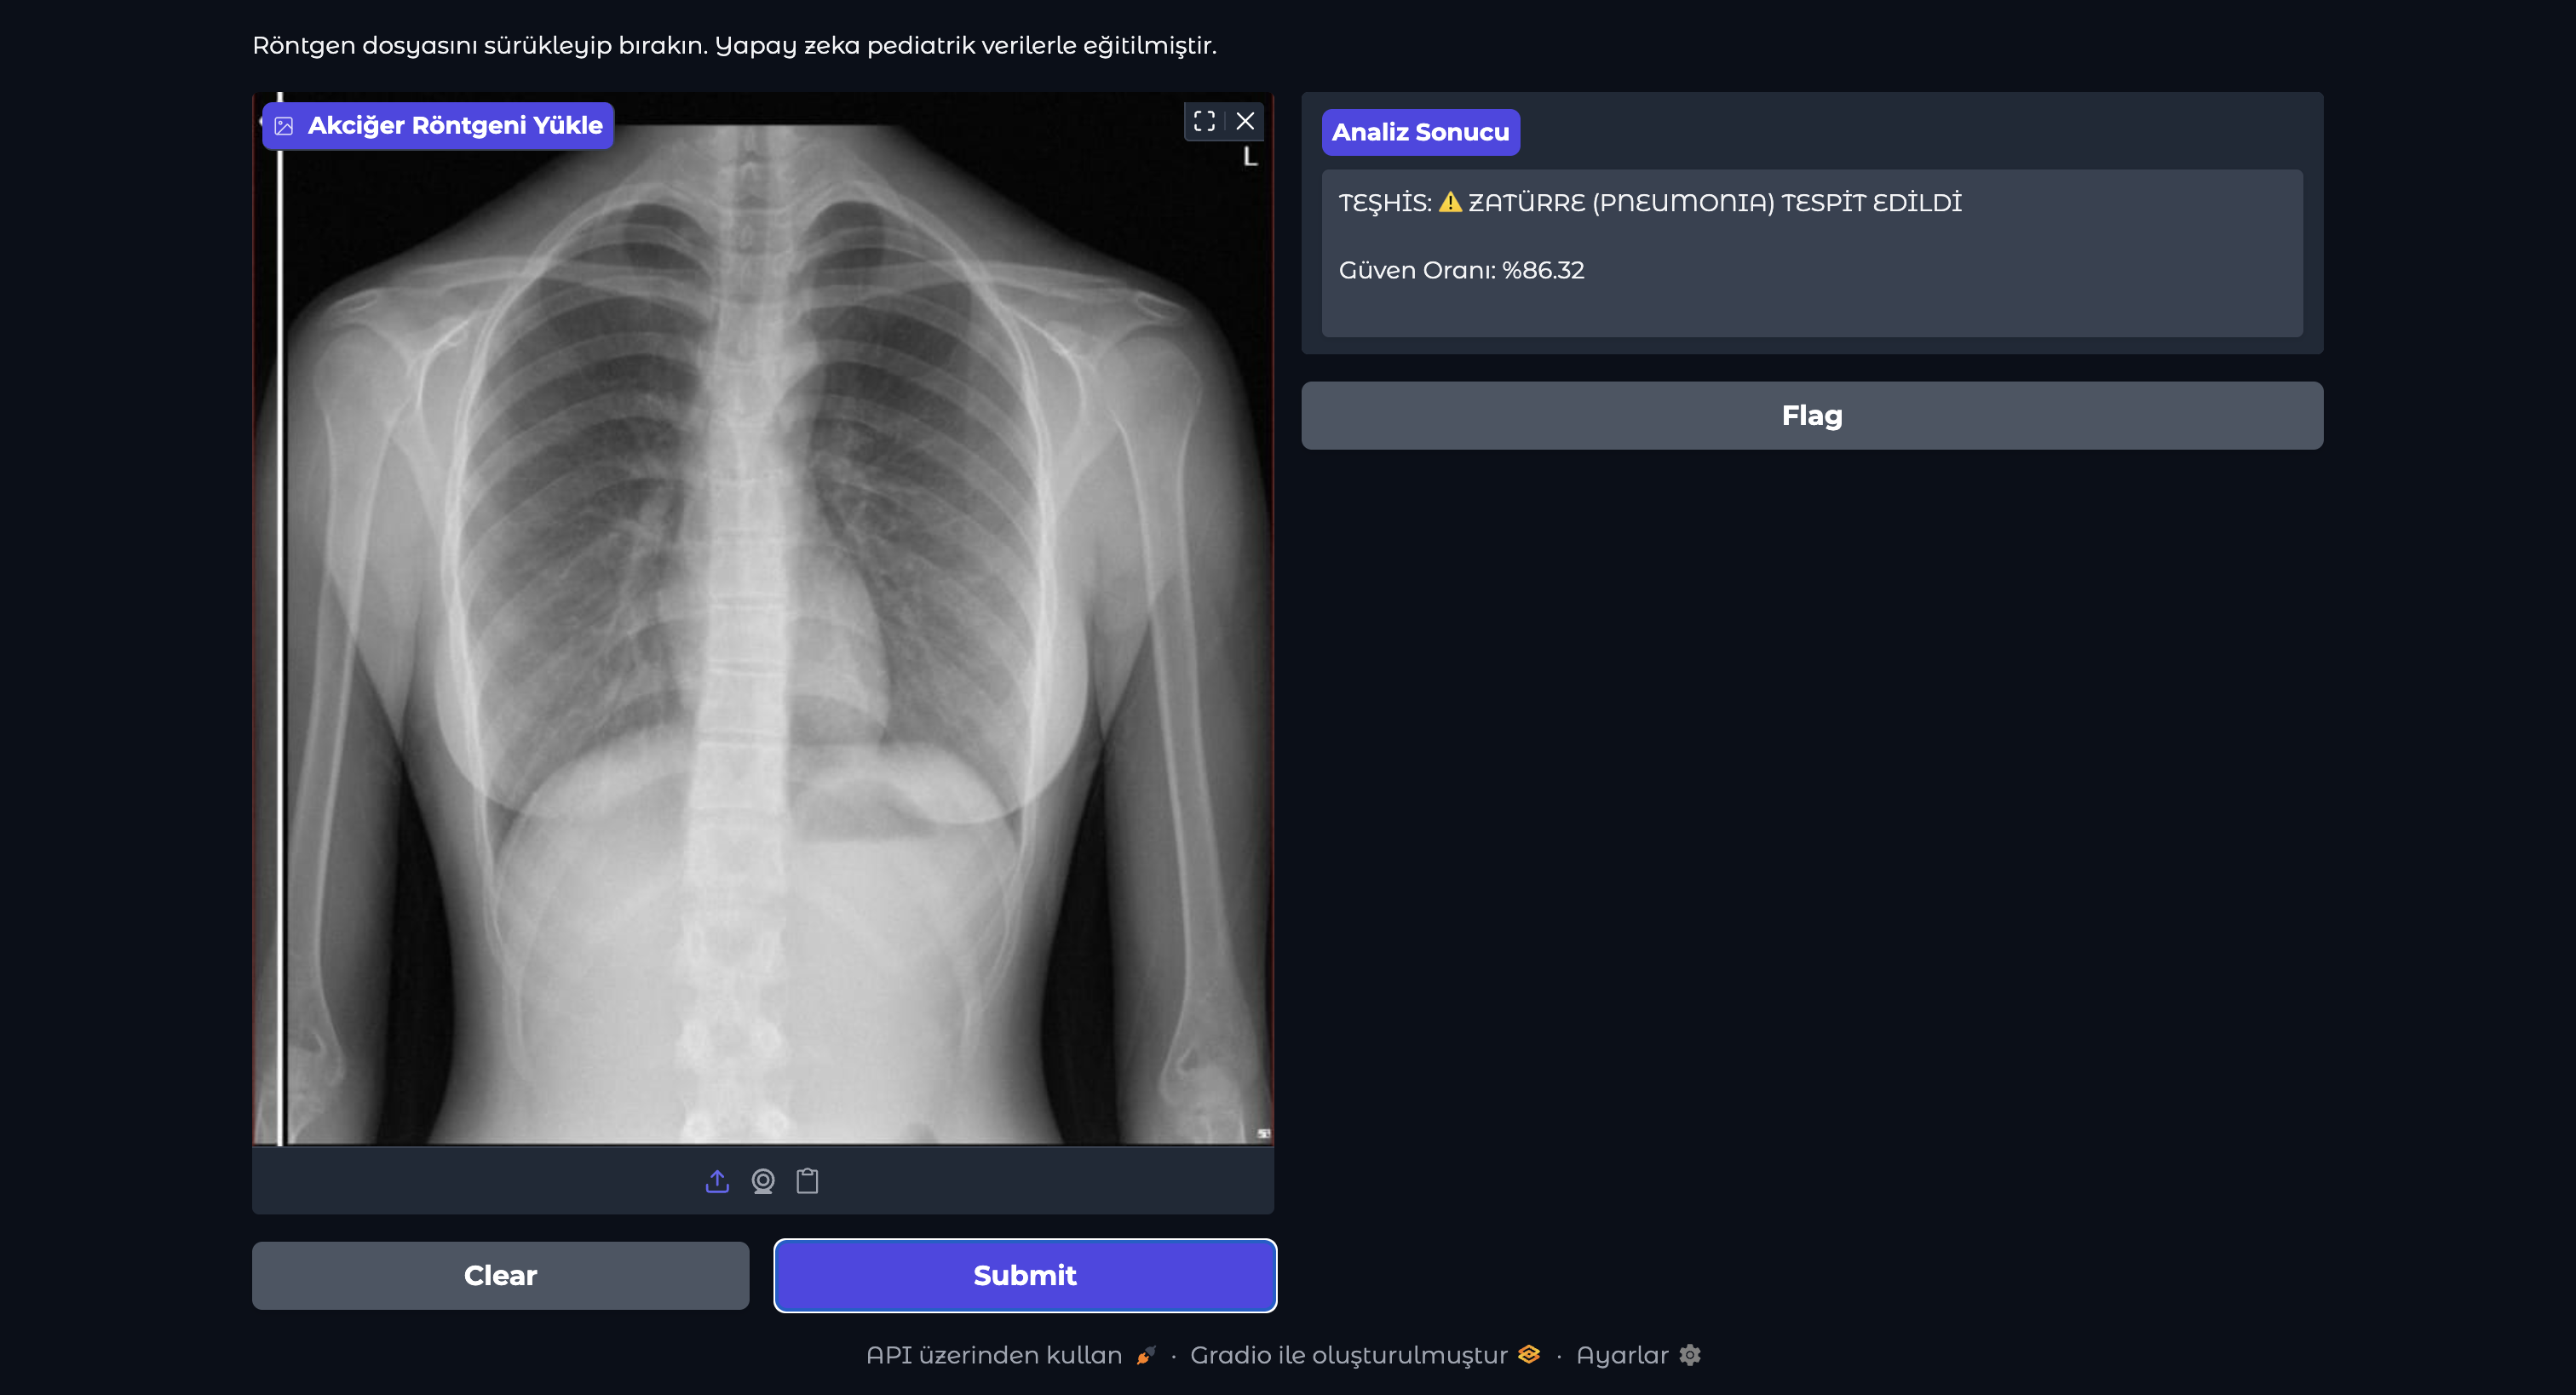

In [ ]:
import os
import pandas as pd
import zipfile


os.environ['KAGGLE_USERNAME'] = "yunusemrekzltepe"
os.environ['KAGGLE_KEY'] = "KGAT_a9777a9e545a4766f28f8e0067c9aea3"


try:
    nih_df = pd.read_csv('Data_Entry_2017.csv', encoding='ISO-8859-1')
    print(" Dosya başarıyla okundu!")
except FileNotFoundError:
    print(" Dosya bulunamadı, yeniden indiriliyor...")
    !kaggle datasets download -d nih-chest-xrays/data -f Data_Entry_2017.csv --force
    !unzip -o Data_Entry_2017.csv.zip
    nih_df = pd.read_csv('Data_Entry_2017.csv', encoding='ISO-8859-1')

# 3. Yetişkin Zatürre ve Normal vakaları filtreleme
nih_zaturre = nih_df[nih_df['Finding Labels'].str.contains('Pneumonia')]
nih_normal = nih_df[nih_df['Finding Labels'] == 'No Finding'].head(len(nih_zaturre))

print(f" NIH Yetişkin Zatürre Sayısı: {len(nih_zaturre)}")
print(f" NIH Yetişkin Sağlıklı Sayısı: {len(nih_normal)}")

ParserError: Error tokenizing data. C error: Expected 2 fields in line 6, saw 4


In [ ]:
import os
import pandas as pd
import zipfile


!rm -f Data_Entry_2017.csv*


os.environ['KAGGLE_USERNAME'] = "yunusemrekzltepe"
os.environ['KAGGLE_KEY'] = "KGAT_a9777a9e545a4766f28f8e0067c9aea3"

print(" NIH Etiket dosyası indiriliyor...")
!kaggle datasets download -d nih-chest-xrays/data -f Data_Entry_2017.csv --force

if os.path.exists('Data_Entry_2017.csv'):
    with open('Data_Entry_2017.csv', 'rb') as f:
        is_zip = f.read(2) == b'PK'
    if is_zip:
        print(" Dosya ZIP formatında, açılıyor...")
        os.rename('Data_Entry_2017.csv', 'temp.zip')
        with zipfile.ZipFile('temp.zip', 'r') as zip_ref:
            zip_ref.extractall()
        os.remove('temp.zip')


try:
    nih_df = pd.read_csv('Data_Entry_2017.csv')
    print(" Liste başarıyla yüklendi!")


    zaturre_listesi = nih_df[nih_df['Finding Labels'].str.contains('Pneumonia', na=False)]
    normal_listesi = nih_df[nih_df['Finding Labels'] == 'No Finding'].head(len(zaturre_listesi))

    print(f"\n Bulunan Yetişkin Zatürre Sayısı: {len(zaturre_listesi)}")
    print(f" Seçilen Yetişkin Sağlıklı Sayısı: {len(normal_listesi)}")

    print("\n--- Veri Örneği ---")
    print(nih_df[['Image Index', 'Finding Labels']].head())

except Exception as e:
    print(f" Hala bir hata var: {e}")

 NIH Etiket dosyası indiriliyor...
Dataset URL: https://www.kaggle.com/datasets/nih-chest-xrays/data
License(s): CC0-1.0
  0% 0.00/924k [00:00<?, ?B/s]
100% 924k/924k [00:00<00:00, 757MB/s]
📦 Dosya ZIP formatında, açılıyor...
✅ Liste başarıyla yüklendi!

 Bulunan Yetişkin Zatürre Sayısı: 1431
 Seçilen Yetişkin Sağlıklı Sayısı: 1431

--- Veri Örneği ---
        Image Index          Finding Labels
0  00000001_000.png            Cardiomegaly
1  00000001_001.png  Cardiomegaly|Emphysema
2  00000001_002.png   Cardiomegaly|Effusion
3  00000002_000.png              No Finding
4  00000003_000.png                  Hernia


In [ ]:
import os

print(" Yetişkin görüntülerinin ilk paketi indiriliyor (images_001.tar.gz)...")
!kaggle datasets download -d nih-chest-xrays/data -f images_001.tar.gz --force

print(" Paket indirildi. Şimdi görüntüler çıkartılıyor")
!mkdir -p /content/images_adult
!tar -xzf images_001.tar.gz -C /content/images_adult

print(" İşlem tamamlandı! Yetişkin resimleri '/content/images_adult/images' klasörüne çıkartıldı.")

 Yetişkin görüntülerinin ilk paketi indiriliyor (images_001.tar.gz)...
Dataset URL: https://www.kaggle.com/datasets/nih-chest-xrays/data
License(s): CC0-1.0
404 Client Error: Not Found for url: https://www.kaggle.com/api/v1/datasets/download/nih-chest-xrays/data/images_001.tar.gz?filename=images_001.tar.gz&raw=false
 Paket indirildi. Şimdi görüntüler çıkartılıyor (bu işlem 1-2 dakika sürebilir)...
tar (child): images_001.tar.gz: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now
 İşlem tamamlandı! Yetişkin resimleri '/content/images_adult/images' klasörüne çıkartıldı.


In [ ]:
# Veri setindeki dosyaların tam listesini görelim
!kaggle datasets files nih-chest-xrays/data

Next Page Token = CfDJ8MM2ZkWST_dHsDXj-CCe3EPiUCKHRZLHA44ulCifxM_tKZvrjZOa_VC9hDEcBxUMJRXxHRd2JLjxGn6aB0bAd1kNKTNVMMCLnRz5Z5-N5eOqfd_W20c491Z7oNK6XXIqF459S0rOXNJP4QCF0k5aJi-HLLAp
name                                   size  creationDate                
----------------------------------  -------  --------------------------  
ARXIV_V5_CHESTXRAY.pdf              8963138  2019-09-24 23:56:19.481000  
BBox_List_2017.csv                    92416  2019-09-24 23:56:19.362000  
Data_Entry_2017.csv                 7861152  2019-09-24 23:56:19.543000  
FAQ_CHESTXRAY.pdf                     72223  2019-09-24 23:56:19.721000  
LOG_CHESTXRAY.pdf                      3919  2019-09-24 23:56:19.430000  
README_CHESTXRAY.pdf                 847223  2019-09-24 23:56:19.407000  
images_001/images/00000001_000.png   457171  2018-02-21 23:57:46.601000  
images_001/images/00000001_001.png   444655  2018-02-21 23:56:51.890000  
images_001/images/00000001_002.png   351772  2018-02-21 23:58:27.109000  
images_

In [ ]:
import os
import pandas as pd
import zipfile

!rm -rf /content/nih_sample* Data_Entry_2017.csv* images_001*

print(" NIH Yetişkin Örnek Seti indiriliyor (2 GB)...")
os.environ['KAGGLE_USERNAME'] = "yunusemrekzltepe"
os.environ['KAGGLE_KEY'] = "KGAT_a9777a9e545a4766f28f8e0067c9aea3"

!kaggle datasets download -d nih-chest-xrays/sample --force

print(" Paket açılıyor...")
with zipfile.ZipFile('sample.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/nih_sample')

print(" NIH Örnek Seti başarıyla hazırlandı.")

 NIH Yetişkin Örnek Seti indiriliyor (2 GB)...
Dataset URL: https://www.kaggle.com/datasets/nih-chest-xrays/sample
License(s): CC0-1.0
100% 4.19G/4.20G [00:53<00:00, 34.5MB/s]
100% 4.20G/4.20G [00:53<00:00, 83.7MB/s]
 Paket açılıyor...
 NIH Örnek Seti başarıyla hazırlandı.


In [ ]:

sample_df = pd.read_csv('/content/nih_sample/sample_labels.csv')

# Yetişkin Zatürre ve Normal vakaları ayır
nih_zaturre = sample_df[sample_df['Finding Labels'].str.contains('Pneumonia')]
nih_normal = sample_df[sample_df['Finding Labels'] == 'No Finding'].head(len(nih_zaturre))

print(f"Örnek Sette Bulunan Yetişkin Zatürre: {len(nih_zaturre)}")
print(f" Örnek Sette Seçilen Yetişkin Sağlıklı: {len(nih_normal)}")

Örnek Sette Bulunan Yetişkin Zatürre: 62
 Örnek Sette Seçilen Yetişkin Sağlıklı: 62


In [ ]:

import os
print("NIH Sample içindeki klasörler:")
!ls -d /content/nih_sample/*/

NIH Sample içindeki klasörler:
/content/nih_sample/sample/


In [ ]:
import os
import shutil

def hibrit_aktarim_son(liste, sinif_adi):
    sayac = 0

    hedef_yol = f'/content/dataset/chest_xray/train/{sinif_adi}'
    os.makedirs(hedef_yol, exist_ok=True)


    kaynak_yol = '/content/nih_sample/sample/images'

    print(f" {sinif_adi} için kaynak kontrol ediliyor: {kaynak_yol}")

    if not os.path.exists(kaynak_yol):
        return " HATA: Yol hala yanlış görünüyor. Lütfen 'nih_sample/sample' içindeki klasör ismini kontrol et."

    for resim_adi in liste['Image Index']:
        kaynak = os.path.join(kaynak_yol, resim_adi)
        hedef = os.path.join(hedef_yol, 'adult_' + resim_adi)

        if os.path.exists(kaynak):
            shutil.copy(kaynak, hedef)
            sayac += 1
    return sayac

print(" Yetişkin resimleri Hibrit eğitime hazırlanıyor...")
z_sayi = hibrit_aktarim_son(nih_zaturre, 'PNEUMONIA')
n_sayi = hibrit_aktarim_son(nih_normal, 'NORMAL')

if isinstance(z_sayi, str):
    print(z_sayi)
else:
    print(f"\n BAŞARILI!")
    print(f" Eğitim setine {z_sayi} adet yetişkin zatürre eklendi.")
    print(f" Eğitim setine {n_sayi} adet yetişkin normal resim eklendi.")
    print(f" Toplam yeni veri: {z_sayi + n_sayi}")

 Yetişkin resimleri Hibrit eğitime hazırlanıyor...
 PNEUMONIA için kaynak kontrol ediliyor: /content/nih_sample/sample/images
 NORMAL için kaynak kontrol ediliyor: /content/nih_sample/sample/images

🎉 BAŞARILI!
 Eğitim setine 62 adet yetişkin zatürre eklendi.
 Eğitim setine 62 adet yetişkin normal resim eklendi.
 Toplam yeni veri: 124


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Eğitim verileri için jeneratör
train_datagen_hybrid = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2 # %20 doğrulama payı
)

print(" Hibrit Eğitim Verileri Hazırlanıyor...")
hybrid_train_generator = train_datagen_hybrid.flow_from_directory(
    train_yolu, # /content/dataset/chest_xray/train
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

hybrid_val_generator = train_datagen_hybrid.flow_from_directory(
    train_yolu,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

 Hibrit Eğitim Verileri Hazırlanıyor...
Found 4273 images belonging to 2 classes.
Found 1067 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.optimizers import Adam


model.compile(
    optimizer=Adam(learning_rate=1e-5), # Çok düşük hız: 0.00001
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print(" Hibrit Eğitim Başlıyor... Yetişkin anatomisi öğretiliyor.")

hybrid_history = model.fit(
    hybrid_train_generator,
    epochs=10,
    validation_data=hybrid_val_generator
)

 Hibrit Eğitim Başlıyor... Yetişkin anatomisi öğretiliyor.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.8996 - loss: 0.2737 - val_accuracy: 0.9157 - val_loss: 0.2293
Epoch 2/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 111s 825ms/step - accuracy: 0.8886 - loss: 0.2798 - val_accuracy: 0.9288 - val_loss: 0.2285
Epoch 3/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 109s 814ms/step - accuracy: 0.8867 - loss: 0.2825 - val_accuracy: 0.9185 - val_loss: 0.2317
Epoch 4/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 110s 819ms/step - accuracy: 0.8862 - loss: 0.2876 - val_accuracy: 0.9175 - val_loss: 0.2300
Epoch 5/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 109s 818ms/step - accuracy: 0.8943 - loss: 0.2665 - val_accuracy: 0.9250 - val_loss: 0.2211
Epoch 6/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 108s 810ms/step - accuracy: 0.8947 - loss: 0.2722 - val_accuracy: 0.9185 - val_loss: 0.2258
Epoch 7/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 108s 807ms/step - accuracy: 0.8877 - loss: 0.2678 - val_accuracy: 0.9072 - val_loss: 0.2318
Epoch 8/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 108s 808ms/step - accuracy: 0.8990 - lo

In [ ]:

model.save('en_iyi_hibrit_zaturre_modeli.keras')
print(" Hibrit model başarıyla kaydedildi!")

 Hibrit model başarıyla kaydedildi!


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def hibrit_test_et(img_yolu):

    img = cv2.imread(img_yolu)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (224, 224))
    img_array = np.expand_dims(img_resized, axis=0) / 255.0


    preds = model.predict(img_array, verbose=0)
    score = preds[0][0]


    label = " ZATÜRRE" if score > 0.5 else " SAĞLIKLI"
    conf = score if score > 0.5 else 1 - score

    plt.imshow(img_rgb)
    plt.title(f"Hibrit Model Kararı: {label} (%{conf*100:.2f})")
    plt.axis('off')
    plt.show()

# Sorunlu resmi buraya yaz
hibrit_test_et('/content/yetiskin_vaka.jpg')

error: OpenCV(4.12.0) /io/opencv/modules/imgproc/src/color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [ ]:
import gradio as gr



def final_analiz(input_img):
    img = cv2.resize(input_img, (224, 224))
    img_array = np.expand_dims(img, axis=0) / 255.0
    prediction = model.predict(img_array)[0][0]

    if prediction > 0.5:
        res = f" ZATÜRRE TESPİT EDİLDİ\nGüven Skoru: %{prediction*100:.2f}"
    else:
        res = f" NORMAL / SAĞLIKLI\nGüven Skoru: %{(1-prediction)*100:.2f}"
    return res

demo = gr.Interface(
    fn=final_analiz,
    inputs=gr.Image(label="Röntgen Yükle"),
    outputs=gr.Textbox(label="Hibrit Model Teşhisi"),
    title="🏥 Akıllı Hibrit Zatürre Tanı Sistemi (V2.0)",
    description="Bu model hem çocuk hem yetişkin verileriyle eğitilmiştir."
)

demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://405f0dc74e8ad7eb89.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
import os
import shutil

def veriyi_cogalt(sinif):
    yol = f'/content/dataset/chest_xray/train/{sinif}'
    adult_resimler = [f for f in os.listdir(yol) if f.startswith('adult_')]
    for resim in adult_resimler:
        for i in range(1, 5): # 4 kopya daha ekle
            shutil.copy(os.path.join(yol, resim), os.path.join(yol, f'copy{i}_{resim}'))

veriyi_cogalt('PNEUMONIA')
veriyi_cogalt('NORMAL')
print(" Yetişkin verileri 5 katına çıkarıldı!")

 Yetişkin verileri 5 katına çıkarıldı!


In [ ]:
# 1. VGG16 tabanının son 4 katmanını eğitime açma
vgg_base = model.layers[0]
vgg_base.trainable = True
for layer in vgg_base.layers[:-4]:
    layer.trainable = False


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print(" Derin Hibrit Eğitim Başlıyor...")
model.fit(hybrid_train_generator, epochs=5, validation_data=hybrid_val_generator)

 Derin Hibrit Eğitim Başlıyor...
Epoch 1/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 128s 870ms/step - accuracy: 0.8986 - loss: 0.2722 - val_accuracy: 0.9269 - val_loss: 0.1743
Epoch 2/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 109s 818ms/step - accuracy: 0.9605 - loss: 0.1128 - val_accuracy: 0.9456 - val_loss: 0.1582
Epoch 3/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 111s 827ms/step - accuracy: 0.9607 - loss: 0.1054 - val_accuracy: 0.9513 - val_loss: 0.1412
Epoch 4/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 110s 824ms/step - accuracy: 0.9733 - loss: 0.0708 - val_accuracy: 0.9569 - val_loss: 0.1508
Epoch 5/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 111s 826ms/step - accuracy: 0.9728 - loss: 0.0847 - val_accuracy: 0.9541 - val_loss: 0.1890


In [ ]:

model.save('final_hibrit_zaturre_modeli.keras')
print(" Final hibrit model başarıyla kaydedildi!")

 Final hibrit model başarıyla kaydedildi!


20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 526ms/step


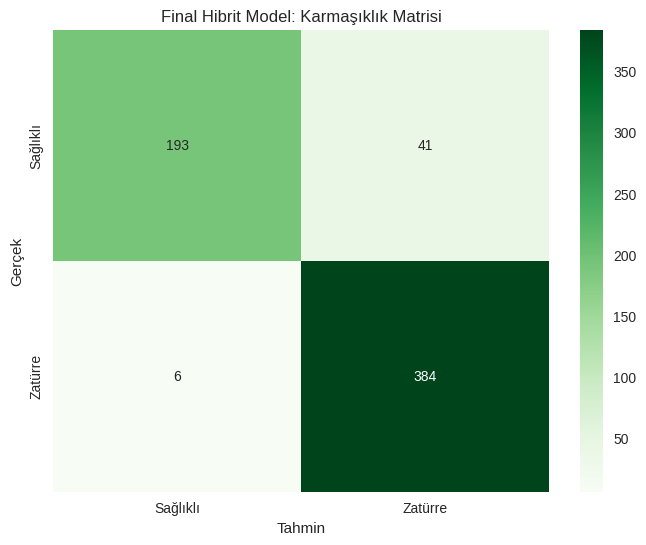

              precision    recall  f1-score   support

           0       0.97      0.82      0.89       234
           1       0.90      0.98      0.94       390

    accuracy                           0.92       624
   macro avg       0.94      0.90      0.92       624
weighted avg       0.93      0.92      0.92       624



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

test_generator.reset()
Y_pred = model.predict(test_generator)
y_pred = (Y_pred > 0.5).astype(int).flatten()
y_true = test_generator.classes

# Matris
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Sağlıklı', 'Zatürre'], yticklabels=['Sağlıklı', 'Zatürre'])
plt.xlabel('Tahmin')
plt.ylabel('Gerçek')
plt.title('Final Hibrit Model: Karmaşıklık Matrisi')
plt.show()

print(classification_report(y_true, y_pred))

In [ ]:
import gradio as gr

def final_radyolog(input_img):
    img = cv2.resize(input_img, (224, 224))
    img_array = np.expand_dims(img, axis=0) / 255.0
    prediction = model.predict(img_array, verbose=0)[0][0]

    if prediction > 0.5:
        return f" ANALİZ: ZATÜRRE BULGUSU TESPİT EDİLDİ\nGüven Skoru: %{prediction*100:.2f}"
    else:
        return f" ANALİZ: NORMAL / SAĞLIKLI AKCİĞER\nGüven Skoru: %{(1-prediction)*100:.2f}"

demo = gr.Interface(
    fn=final_radyolog,
    inputs=gr.Image(label="Röntgen Dosyası Yükleyin"),
    outputs=gr.Textbox(label="Uzman Yapay Zeka Teşhisi"),
    title="🏥 Profesyonel Hibrit Zatürre Teşhis Portalı",
    description="Bu sistem hem çocuk (pediatrik) hem de yetişkin (NIH) veri setleri kullanılarak derinlemesine eğitilmiştir."
)

demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://2538f12209d33a026b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 467ms/step


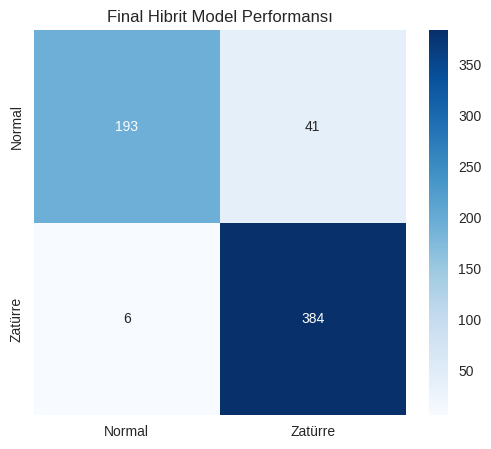

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

test_generator.reset()
y_pred = (model.predict(test_generator) > 0.5).astype(int).flatten()
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Zatürre'], yticklabels=['Normal', 'Zatürre'])
plt.title('Final Hibrit Model Performansı')
plt.show()